<a href="https://colab.research.google.com/github/alessandronicolini/IotHomeworks/blob/main/HW2/IoT_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# dataset
import argparse
import numpy as np
import os
import pandas as pd

# metric class
from keras.metrics import Metric

# call backs
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback

# tensorboard
%load_ext tensorboard
!rm -rf ./tb_log/ 
from tensorboard.plugins.hparams import api as hp

# models
from keras.models import Model
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dense
from keras.layers import Flatten, Input, Concatenate, LSTM
import tensorflow as tf
from keras.optimizers import Adam
from keras.losses import mse

# plot
import matplotlib.pyplot as plt

# save history
import pickle 
import os

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##Dataset

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True,
    cache_dir='.', cache_subdir='data')
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

column_indices = [2, 5]
columns = df.columns[column_indices]
data = df[columns].values.astype(np.float32)

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

input_width = 6
LABEL_OPTIONS = 6 #args.labels


class WindowGenerator:
    def __init__(self, input_width, label_options, mean, std):
        self.input_width = input_width
        self.label_options = label_options
        self.mean = tf.reshape(tf.convert_to_tensor(mean), [1, 1, 2])
        self.std = tf.reshape(tf.convert_to_tensor(std), [1, 1, 2])

    def split_window(self, features):
        inputs = features[:, :-6, :]
        labels= features[:, -6:, :]
        num_labels = 6

        inputs.set_shape([None, self.input_width, 2])
        labels.set_shape([None, num_labels, 2])

        return inputs, labels

    def normalize(self, features):
        features = (features - self.mean) / (self.std + 1.e-6)

        return features

    def preprocess(self, features):
        inputs, labels = self.split_window(features)
        inputs = self.normalize(inputs)

        return inputs, labels

    def make_dataset(self, data, train):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=input_width+6,
                sequence_stride=1,
                batch_size=32) 
        
        ds = ds.map(self.preprocess)
        ds = ds.cache()
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds


generator = WindowGenerator(input_width, LABEL_OPTIONS, mean, std)
train_ds = generator.make_dataset(train_data, True)
val_ds = generator.make_dataset(val_data, False)
test_ds = generator.make_dataset(test_data, False)

13574144/13568290 [==============================] - 0s 0us/step


##Metric classes
exploited to define separately temperature mae and humidity mae

In [3]:
# METRIC CLASS

class MaeTemp(Metric):
  def __init__(self, name="mae_T", **kwargs):
    super().__init__(name, **kwargs)
    self.total = self.add_weight('total', initializer='zeros') # accumulate the total error
    self.count = self.add_weight('count', initializer='zeros') # accumulate the number of elements 

  def reset_state(self):
    self.count.assign(tf.zero_like(self.count))
    self.total.assign(tf.zero_like(self.total))

    return

  def update_state(self, y_true, y_pred, sample_weight=None):
    # compute on how many elements you evaluate the error
    n_elements = 32*y_pred.shape[1] # 32*6
    
    # evaluate the error and accumulate first across batch elements and then 
    # across columns to get the total error related to temperature and humidity
    error = tf.abs(y_pred[:,:,0] - y_true[:,:,0]) # shape=[32, 6, 1] CONSIDER THE TEMPERATURE DATA
    error  = tf.reduce_sum(error, axis=0) # shape=[6,1]
    error = tf.reduce_sum(error, axis=0) # shape=[1]

    # update state variables
    self.total.assign_add(error)
    self.count.assign_add(n_elements)

    return
  
  def result(self):
    result = tf.math.divide_no_nan(self.total, self.count)

    return result


class MaeHum(Metric):
  def __init__(self, name="mae_H", **kwargs):
    super().__init__(name, **kwargs)
    self.total = self.add_weight('total', initializer='zeros') # accumulate the total error
    self.count = self.add_weight('count', initializer='zeros') # accumulate the number of elements 

  def reset_state(self):
    self.count.assign(tf.zero_like(self.count))
    self.total.assign(tf.zero_like(self.total))

    return

  def update_state(self, y_true, y_pred, sample_weight=None):
    # compute on how many elements you evaluate the error
    n_elements = 32*y_pred.shape[1]# 32*6
    
    # evaluate the error and accumulate first across batche elements and then 
    # across columns to get the total error related to temperature and humidity
    error = tf.abs(y_pred[:,:,1] - y_true[:,:,1]) # shape=[32, 6, 1] CONSIDER THE HUMIDITY DATA
    error  = tf.reduce_sum(error, axis=0) # shape=[6,1]
    error = tf.reduce_sum(error, axis=0) # shape=[1]

    # update state variables
    self.total.assign_add(error)
    self.count.assign_add(n_elements)

    return

  def result(self):
    result = tf.math.divide_no_nan(self.total, self.count)

    return result



## Models definitions
hparams is the dict which contains the params configuration

In [4]:
# Convolutional Neural Network
def get_CNN(hparams):
  inputs = Input(shape=(6,2))
  x = Conv1D(filters=64, kernel_size=3, activation="relu")(inputs)
  x = Flatten()(x)
  x = Dense(units=hparams['num_units'], activation="relu")(x)
  x = Dense(units=12)(x)
  model = Model(inputs=inputs, outputs=tf.reshape(x,[-1,6,2]))

  model.compile(optimizer=Adam(learning_rate=hparams['lr']),
              loss=mse,
              metrics=[MaeTemp(), MaeHum()])
  
  return model

# THE FOLLOWING MODELS MUST BE UPDATED TO SUPPORT hparams ARGUMENT! At the 
# moment is only inserted as input argument but not actually used.
# Multi Layer Perceptron
def get_MLP(hparams):
  input = Input(shape=(6,2))
  x = Flatten()(input)
  x = Dense(units=64, activation='relu')(x)
  x = Dense(units=64, activation='relu')(x)
  x = Dense(units=12)(x)
  model = Model(inputs=input, outputs=tf.reshape(x,[-1,6,2]))

  model.compile(optimizer=Adam(learning_rate=5e-4),
              loss=mse,
              metrics=[MaeTemp(), MaeHum()])

  return model

# Long short term memory
def get_LSTM(hparams):
  inputs = Input(shape=(6,2))
  x = LSTM(64)(inputs)
  x = Flatten()(x)
  x = Dense(units=12)(x)
  model = Model(inputs=inputs, outputs=tf.reshape(x,[-1,6,2]))

  model.compile(optimizer=Adam(learning_rate=5e-4),
              loss=mse,
              metrics=[MaeTemp(), MaeHum()])

  return model

#print(model.summary())
#plot_model(model, 'cnn.png', show_shapes=True)

### Custom model checkpoint class

In [55]:
class CustomCheckPoint(Callback):
  def __init__(self, chkp_dir):
    super(CustomCheckPoint, self).__init__()
    self.min_loss = np.inf
    self.mae_T_thr = 0.5
    self.mae_H_thr = 1.8
    self.chkp_dir = chkp_dir

  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get('val_loss')
    current_mae_T = logs.get('val_mae_T')
    current_mae_H = logs.get('val_mae_H')

    if (current_loss <= self.min_loss and 
        current_mae_T <= self.mae_T_thr and 
        current_mae_H <= self.mae_H_thr):
      self.min_loss = current_loss
      logs['best_epoch'] = epoch # Idk why but the value is appended, not overwritten
      self.model.save(self.chkp_dir,)

###Hyperparameters tuning
Try hyper parameters tuning with tensorboard. The following example holds for the CNN model, you can simply adapt it to the other models. The tuned hyperparameters are: 
- learning rate: 1e-4, 1e-3
- dense layer number of units: 16, 32, 64

In [56]:
conf_num = 0 # params configuration identifier
model_name = 'CNN'

# make history directory
try: 
  os.mkdir('history')
except FileExistsError:
  pass

for units in [16, 32, 64]:
  for lr in [1e-4, 1e-3]:

    # define current hparams configuration
    hparams = {'num_units':units, 'lr':lr}
    conf_name = "conf_%d" % conf_num
    print('--- Starting trial: %s' % conf_name)
    print(hparams)

    # set directories
    chkp_dir = './checkpoint/' + model_name + '_chkp_' + conf_name + "_best" # current configuration best model dir

    # callbacks
    es_cb = EarlyStopping(patience=5, verbose=1, mode='min') # monitor=val_loss by default
    chkp_cb = CustomCheckPoint(chkp_dir)

    # get the model
    model = get_CNN(hparams)

    # fit the model
    history = model.fit(
        train_ds, 
        batch_size=32,    
        epochs=25, 
        validation_data=val_ds,
        callbacks=[chkp_cb, es_cb]
        )
    
    # save history for current configuration
    with open('history/'+ model_name +'_'+ conf_name + '.pkl', 'wb') as binfile:
      pickle.dump(history.history, binfile, protocol=pickle.HIGHEST_PROTOCOL)

    # update conf num
    conf_num += 1

--- Starting trial: conf_0
{'num_units': 16, 'lr': 0.0001}
Epoch 1/25
9200/9200 [==============================] - 14s 2ms/step - loss: 591.2134 - mae_T: 5.7956 - mae_H: 23.0086 - val_loss: 43.3817 - val_mae_T: 5.0329 - val_mae_H: 5.2910
Epoch 2/25
9200/9200 [==============================] - 14s 2ms/step - loss: 17.8748 - mae_T: 1.7797 - mae_H: 3.6524 - val_loss: 10.0489 - val_mae_T: 1.4092 - val_mae_H: 2.8152
Epoch 3/25
9200/9200 [==============================] - 14s 2ms/step - loss: 8.0382 - mae_T: 0.9315 - mae_H: 2.5408 - val_loss: 6.6537 - val_mae_T: 0.8232 - val_mae_H: 2.2568
Epoch 4/25
9200/9200 [==============================] - 17s 2ms/step - loss: 6.2341 - mae_T: 0.7732 - mae_H: 2.1754 - val_loss: 5.5724 - val_mae_T: 0.7028 - val_mae_H: 1.9942
Epoch 5/25
9200/9200 [==============================] - 14s 2ms/step - loss: 5.4599 - mae_T: 0.6680 - mae_H: 2.0075 - val_loss: 5.2159 - val_mae_T: 0.6248 - val_mae_H: 1.9578
Epoch 6/25
9200/9200 [==============================] - 14s 

### Plots
Plot training and validation mae T, mae H, and loss for each configuration. Validation values corresponding to the best epoch are highlighted. This let you understand what is the best hyperparameters configuration.

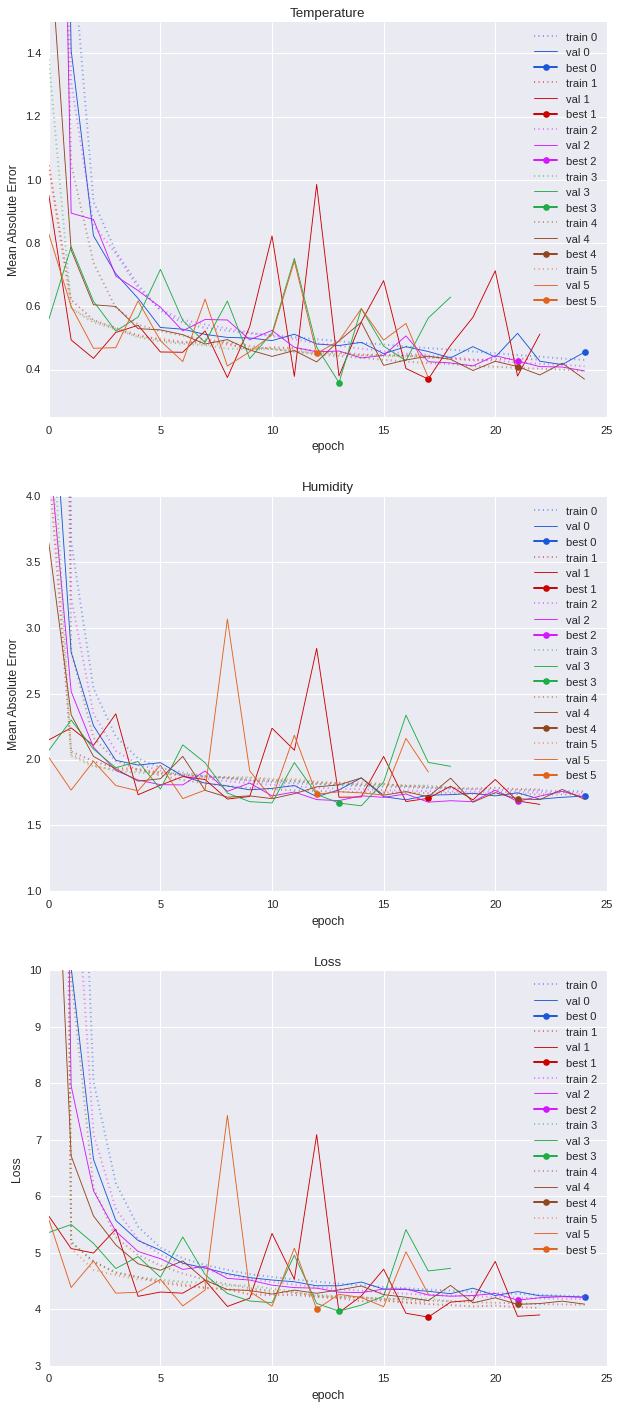

In [160]:
import random
plt.style.use('seaborn')
fig, [axT, axH, axL] = plt.subplots(nrows=3, ncols=1, figsize=(9,21))

# generate six random colors
color = ['#1a57db', '#1cad45', '#d417ff',  '#e3611b', '#91451f', '#cc0000']
for chkp in os.listdir('./history'):
  name = chkp.split('_')[0]
  
  if name == 'CNN':
    conf_num = int(chkp.split('.')[0][-1])

    with open('./history/'+chkp, 'rb') as binfile:
      history = pickle.load(binfile)
    
    best_epoch = history['best_epoch'][-1]

    axT.plot(history['mae_T'], linestyle='dotted', alpha=0.5, color=color[conf_num])
    axT.plot(history['val_mae_T'], color=color[conf_num], linewidth=0.8)#,linestyle='dashed')
    axT.plot(best_epoch, history['val_mae_T'][best_epoch], 
             marker='o',markersize=6, color=color[conf_num])
    axT.set_title('Temperature')
    axT.set_ylabel('Mean Absolute Error')
    axT.set_xlabel('epoch')
    

    axH.plot(history['mae_H'], linestyle='dotted', alpha=0.5, color=color[conf_num])
    axH.plot(history['val_mae_H'], color=color[conf_num], linewidth=0.8)
    axH.plot(best_epoch, history['val_mae_H'][best_epoch], 
             marker='o',markersize=6, color=color[conf_num])
    axH.set_title('Humidity')
    axH.set_ylabel('Mean Absolute Error')
    axH.set_xlabel('epoch')

    axL.plot(history['loss'], linestyle='dotted', alpha=0.5, color=color[conf_num])
    axL.plot(history['val_loss'], color=color[conf_num], linewidth=0.8)
    axL.plot(best_epoch, history['val_loss'][best_epoch], 
             marker='o',markersize=6, color=color[conf_num])
    axL.set_title('Loss')
    axL.set_ylabel('Loss')
    axL.set_xlabel('epoch')

kinds = ['train', 'val', 'best']
runs = [str(i) for i in range(6)]
labels = []
for run in runs:
  for kind in kinds:
    labels.append(kind+" "+run)

axT.legend(labels, loc='upper right')
axT.set_ylim(0.25,1.5)
axH.legend(labels, loc='upper right')
axH.set_ylim(1,4)
axL.legend(labels, loc='upper right')
axL.set_ylim(3,10)
plt.show()

### Test model
Load the best model and evaluate it on the testset

In [ ]:
# test the model
best_model = tf.keras.models.load_model(
    './checkpoint/CNN_chkp_conf_1_best',
    custom_objects={'MaeTemp':MaeTemp, 'MaeHum':MaeHum})
results = best_model.evaluate(test_ds, batch_size=32)

###Save as TFLite model

In [ ]:
import tempfile

# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model:", os.path.getsize(float_file))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpzj_yu3pg/assets
Float model: 73852
